In [56]:
# basic imports
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
warnings.filterwarnings('ignore')

# imports for data processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.model_selection import cross_val_predict, KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

# imports for models
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Ajouter le chemin du projet au PATH
sys.path.append(os.path.abspath(".."))

from modules.data_import import loadAndMergeData, exportDataCSV

In [57]:
# Charger les données
data = pd.read_csv("../dataClean.csv")

data_num = data.select_dtypes(include=[np.number]) 
num_attribs = list(data_num)

data_cat = data.select_dtypes(include=[object])
cat_attribs = list(data_cat)

# Pipeline pour les attributs numériques
num_pipeline = Pipeline([
        #('attribs_adder', CombinedAttributesAdder()), # combination des valeurs pas encore fait
        ('std_scaler', StandardScaler()),
    ])

# Pipeline pours les attributs catégoriel avec un ordinal encoder
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OrdinalEncoder(), cat_attribs),
    ])

data_prepared = full_pipeline.fit_transform(data)

cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.get_feature_names_out(cat_attribs))

columns = num_attribs + cat_one_hot_attribs

data_prepared_df = pd.DataFrame(data_prepared, columns=columns)

# Equilibrage des données pour avoir le même nombre d'attrition oui et attrition non
indices_0 = np.where(data_prepared_df["Attrition"] == 0)[0]  # Indices où y=0
indices_1 = np.where(data_prepared_df["Attrition"] == 1)[0]  # Indices où y=1
indices_0_under = np.random.choice(indices_0, size=len(indices_1), replace=False)
indices_balanced = np.concatenate([indices_0_under, indices_1])

indices_balanced_pd = pd.DataFrame(data_prepared_df.loc[indices_balanced], columns=columns)

indices_balanced_pd["Attrition"].value_counts()

X = indices_balanced_pd.drop("Attrition", axis=1)
y = indices_balanced_pd["Attrition"]

In [58]:
# définition des models
models = {
  #"Perceptron": Perceptron(random_state=42),
  #"LogisticRegression": LogisticRegression(random_state=42),
  "DecisionTree": DecisionTreeClassifier(random_state=42),
  "RandomForest": RandomForestClassifier(random_state=42)
}

# division du dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
# entrinement des modèles
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

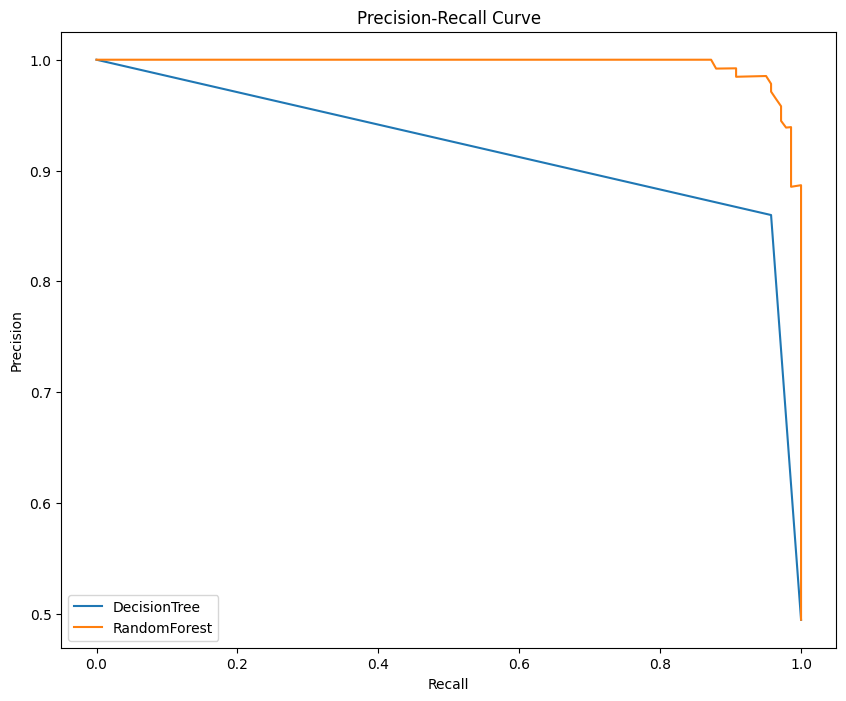

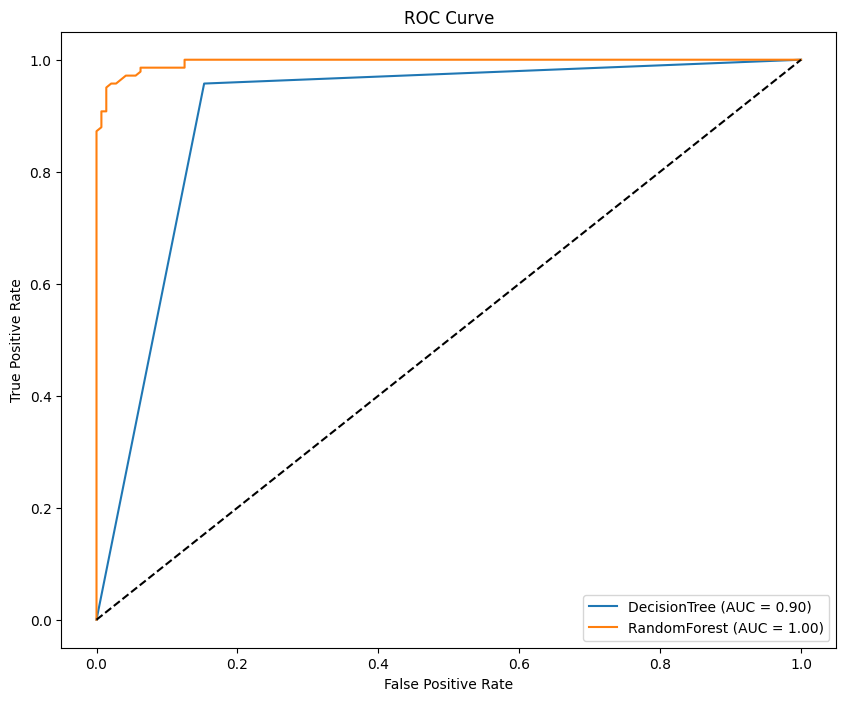

In [60]:
# Tracer les courbes de Précision-Rappel
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        plt.plot(recall, precision, label=f"{name}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

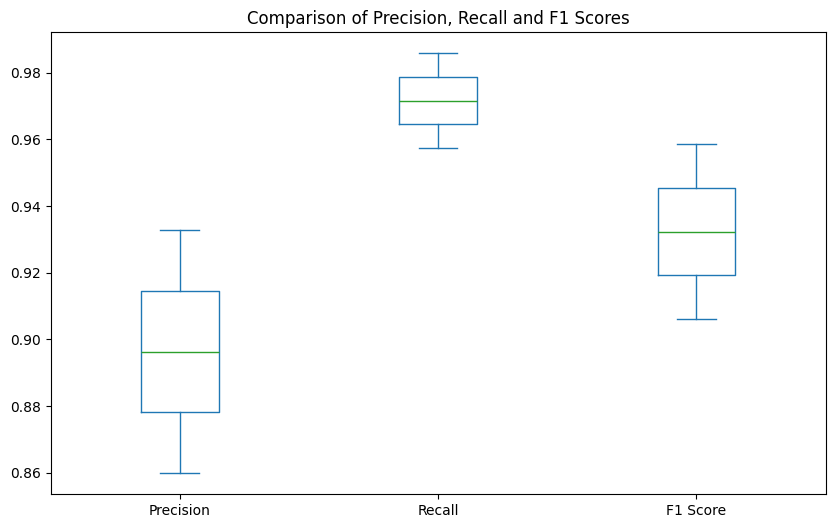

In [61]:
# Comparaison des scores de précision, rappel et F1
precision_scores = []
recall_scores = []
f1_scores = []

for name, y_pred in predictions.items():
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
score_df = pd.DataFrame({
    'Model': models.keys(),
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

score_df.plot(kind='box', figsize=(10, 6))
plt.title("Comparison of Precision, Recall and F1 Scores")
plt.show()


In [77]:
# affichage des scores
scores = []

for name, y_pred in predictions.items():
    y_proba = models[name].predict_proba(X_test)[:, 1] if hasattr(models[name], "predict_proba") else None
    auc_score = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    scores.append({
        'Model': name,
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': auc_score
    })

scores_df = pd.DataFrame(scores)
print(scores_df)

          Model  Precision    Recall  F1 Score       AUC
0  DecisionTree   0.859873  0.957447  0.906040  0.902335
1  RandomForest   0.932886  0.985816  0.958621  0.995937


In [63]:
# affichage des temps d'entrainement et de prédiction
trainingTimes = []
predictionTimes = []

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    trainingTimes.append(time.time() - start_time)

    start_time = time.time()
    model.predict(X_test)
    predictionTimes.append(time.time() - start_time)
    
time_df = pd.DataFrame({
    'Model': models.keys(),
    'Training Time (s)': trainingTimes,
    'Prediction Time (s)': predictionTimes
})
print(time_df)


          Model  Training Time (s)  Prediction Time (s)
0  DecisionTree            0.01016             0.001250
1  RandomForest            0.23860             0.009856


---
## Recherche d'hyperparamètre

In [73]:
# création d'un dictionnaire pour les résultats de recherche
results = {}

# définition des hyperparamètres par model
modelsWithHyperParams = {
  "DecisionTree": (DecisionTreeClassifier(random_state=42), {"criterion": ["gini", "entropy", "log_loss"], "max_depth": [None, 3, 5, 10], "min_samples_leaf": [1, 3, 5], "min_samples_split": [2, 3, 4]}),
  "RandomForest": (RandomForestClassifier(random_state=42), {"n_estimators": [100, 200, 300], "criterion": ["gini", "entropy", "log_loss"], "max_depth": [None, 3, 5, 10], "min_samples_leaf": [1, 3, 5], "min_samples_split": [2, 3, 4]})
}

In [74]:
import time

# recherche des meilleurs hyperparamètres
for name, (model, params) in modelsWithHyperParams.items():
  start_time = time.time()
  grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
  grid_search.fit(X, y)
  print(f"{name} ({(time.time() - start_time):.2f}s): {grid_search.best_params_}")
  results[name] = (grid_search.best_params_, time.time() - start_time) 

DecisionTree (5.77s): {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
RandomForest (734.72s): {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
# affichage des résultats
for name, (params, time) in results.items():
  print(f"{name} ({time:.2f}s): {params}")

---
## Pipeline avec paramètres

In [83]:
# définition des models avec les hyper paramètres trouvé plus haut
modelsWithParams = {
    "DecisionTree": DecisionTreeClassifier(random_state=42, criterion= 'gini', max_depth= None, min_samples_leaf= 1, min_samples_split= 3),
    "RandomForest": RandomForestClassifier(random_state=42, criterion= 'entropy', max_depth= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300) 
}

In [84]:
import time
# affichage des temps d'entrainement et de prédiction avec les hyperparamètres
trainingTimes = []
predictionTimes = []

for name, model in modelsWithParams.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    trainingTimes.append(time.time() - start_time)

    start_time = time.time()
    model.predict(X_test)
    predictionTimes.append(time.time() - start_time)
    
time_df = pd.DataFrame({
    'Model': models.keys(),
    'Training Time (s)': trainingTimes,
    'Prediction Time (s)': predictionTimes
})
print(time_df)

          Model  Training Time (s)  Prediction Time (s)
0  DecisionTree           0.011193             0.001899
1  RandomForest           1.068966             0.046567


In [85]:
# comparaison avec les temps sans hyperparamètres
for index in range(len(models)):
    print(f"différence de temps d'entrainement pour le {time_df["Model"][index]} : {(time_df["Training Time (s)"][index] - time_df_params["Training Time (s)"][index]):.5f}s c'est à dire une amélioration de {100 - (100 * time_df_params["Training Time (s)"][index] / time_df["Training Time (s)"][index]):.0f}%")
    print(f"différence de temps de prédiction pour le {time_df["Model"][index]} : {(time_df["Prediction Time (s)"][index] - time_df_params["Prediction Time (s)"][index]):.5f}s c'est à dire une amélioration de {100 - (100 * time_df_params["Prediction Time (s)"][index] / time_df["Prediction Time (s)"][index]):.0f}%")
    print("---")

différence de temps d'entrainement pour le DecisionTree : -0.00184s c'est à dire une amélioration de -16%
différence de temps de prédiction pour le DecisionTree : 0.00060s c'est à dire une amélioration de 32%
---
différence de temps d'entrainement pour le RandomForest : 0.74959s c'est à dire une amélioration de 70%
différence de temps de prédiction pour le RandomForest : 0.03007s c'est à dire une amélioration de 65%
---


In [86]:
predictionsWithParams = {}

for name, model in modelsWithParams.items():
    predicted = cross_val_predict(model, X, y, cv=5) # KFold(n_splits=2)
    score = cross_validate(model, X, y, cv=5, return_train_score=True, return_estimator=True)
    predictionsWithParams[name] = (predicted, score)

DecisionTree
precision score : 0.8495145631067961
recall score : 0.9845288326300985
f1 score : 0.9120521172638436
accuracy score : 0.9050632911392406
---
train score : [0.99912049 0.99912049 1.         0.99912127 0.99912127]
train score mean : 0.9992967031608169
test score : [0.90175439 0.90526316 0.92605634 0.88028169 0.91197183]
test score mean : 0.9050654806029158
---


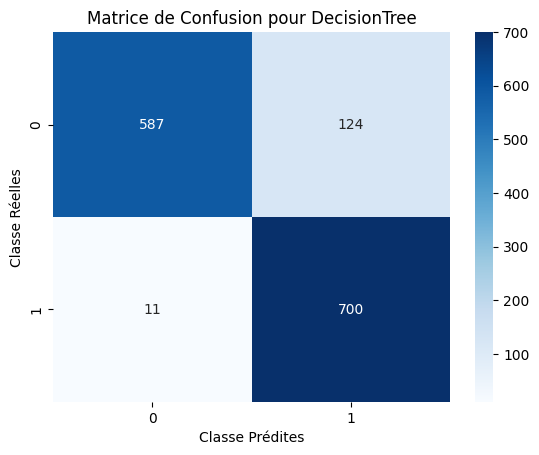

RandomForest
precision score : 0.9162371134020618
recall score : 1.0
f1 score : 0.9562878278412912
accuracy score : 0.9542897327707455
---
train score : [1. 1. 1. 1. 1.]
train score mean : 1.0
test score : [0.96491228 0.94736842 0.95774648 0.95422535 0.9471831 ]
test score mean : 0.95428712626637
---


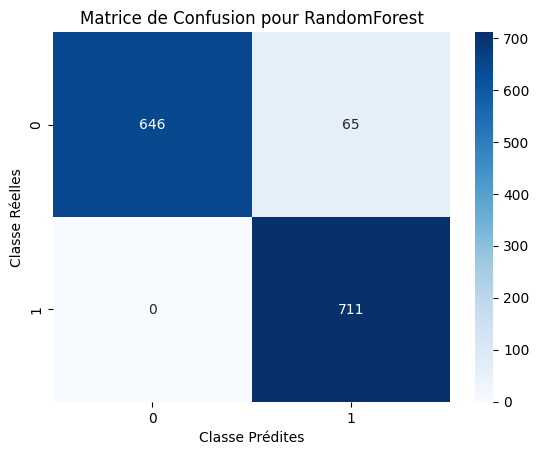

In [87]:
for name, (predicted, score) in predictionsWithParams.items():
    print(name)
    print(f"precision score : {precision_score(y, predicted)}")
    print(f"recall score : {recall_score(y, predicted)}")
    print(f"f1 score : {f1_score(y, predicted)}")
    print(f"accuracy score : {accuracy_score(y, predicted)}")
    print(f"---")
    print(f"train score : {score['train_score']}")
    print(f"train score mean : {score['train_score'].mean()}")
    print(f"test score : {score['test_score']}")
    print(f"test score mean : {score['test_score'].mean()}")
    print(f"---")
    plt.figure()
    sns.heatmap(confusion_matrix(y, predicted), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matrice de Confusion pour {name}")
    plt.xlabel("Classe Prédites")
    plt.ylabel("Classe Réelles")
    plt.show()

In [88]:
for name, (predicted, score) in predictionsWithParams.items():
    if name == "DecisionTree":
        fig = plt.figure(figsize=(25,10), dpi=800, linewidth=0.1)
        plot_tree(score["estimator"][0], feature_names=X.columns, class_names=['Attrition', "Pas Attrition"], filled=True)
        plt.show()
    elif name == "RandomForest":
        fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (130,10), dpi=800)
        fig.tight_layout()
        for index in range(0, 5):
            plot_tree(score["estimator"][0][index], feature_names = X.columns, class_names=['Attrition', "Pas Attrition"], filled = True, ax = axes[index]);
            axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
        plt.show()
    else :
        print("No tree to plot")

KeyboardInterrupt: 

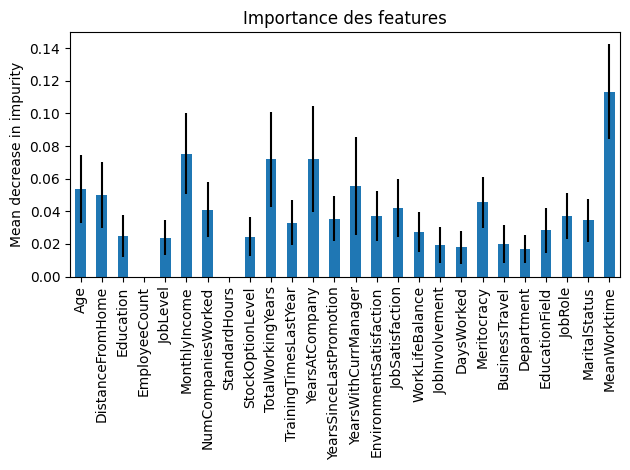

In [94]:
imp = models["RandomForest"].feature_importances_
std = np.std([tree.feature_importances_ for tree in models["RandomForest"].estimators_], axis=0)
for_imp = pd.Series(imp, index=X.columns)
fig, ax = plt.subplots()
for_imp.plot(yerr=std, ax=ax, kind='bar')
ax.set_title("Importance des features")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

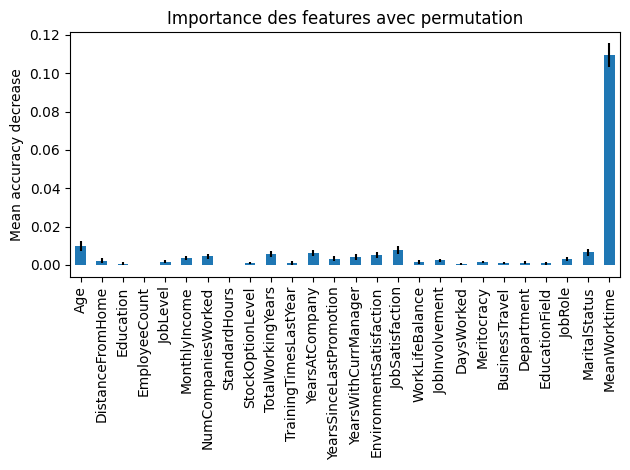

In [95]:
from sklearn.inspection import permutation_importance
start_time = time.time()
result = permutation_importance(models["RandomForest"], X, y, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
forest_importances = pd.Series(result.importances_mean, index=X.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Importance des features avec permutation")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()